<center>&copy; | Ghassen <strong>MARRAKCHI</strong> - 2022</center>

<img src="__src/LIPN.png" style="" width="300">
<hr>

<h1 style="text-align:center;color:#5a84ba"><center>Benchmarking Clustering DataStream</center></h1>
<h2><center><strong><font color='#3f4a4f'>Classification DataStream Benchmark Exploratory</font></strong></center></h2>

<hr>
<h3><center><strong><font color='#3f4a4f'>III - Analysis</font></strong></center></h3>
<hr>

<h4><strong><font color='#353b38'>Plan de Travail</font></strong></h4>

<ol style="list-style-type: upper-roman;">
    <li><a href="I- Introduction.ipynb">Introduction</a></li>
    <li><a href="II- Exploration-and-Pre-processing.ipynb">Exploration</a></li>
    <li><strong>Analysis</strong></li>
    <li><a href="IV- Optimisation.ipynb">Optimisation</a></li>
</ol>

<hr>
<h4><strong><font color='#353b38'>Objectifs</font></strong></h4>

- Visualiser les données.
- Vérifier l'éligiilité des données à la tache de clustering.

<hr>
<h4 id="SOMMAIRE"><strong><font color='#353b38'>Jeux de données</font></strong></h4>

<ul>
    <li><a href="#INSECTS_abrupt_balanced_norm"><strong>INSECTS_abrupt_balanced_norm</strong></a></li>
    <li><a href="#INSECTS_abrupt_imbalanced_norm"><strong>INSECTS_abrupt_imbalanced_norm</strong></a></li>
    <li><a href="#INSECTS_gradual_balanced_norm"><strong>INSECTS_gradual_balanced_norm</strong></a></li>
    <li><a href="#INSECTS_gradual_imbalanced_norm"><strong>INSECTS_gradual_imbalanced_norm</strong></a></li>
    <li><a href="#INSECTS_incremental_abrupt_balanced_norm"><strong>INSECTS_incremental_abrupt_balanced_norm</strong></a></li>
    <li><a href="#INSECTS_incremental_abrupt_imbalanced_norm"><strong>INSECTS_incremental_abrupt_imbalanced_norm</strong></a></li>
    <li><a href="#INSECTS_incremental_balanced_norm"><strong>INSECTS_incremental_balanced_norm</strong></a></li>
    <li><a href="#INSECTS_incremental_imbalanced_norm"><strong>INSECTS_incremental_imbalanced_norm</strong></a></li>
    <li><a href="#INSECTS_incremental_reoccurring_balanced_norm"><strong>INSECTS_incremental_reoccurring_balanced_norm</strong></a></li>
    <li><a href="#INSECTS_incremental_reoccurring_imbalanced_norm"><strong>INSECTS_incremental_reoccurring_imbalanced_norm</strong></a></li>
    <li><a href="#INSECTS_out_of_control_norm"><strong>INSECTS_out_of_control_norm</strong></a></li>
</ul>

<h4><strong><font color='#353b38'>Configuration générale du notebook</font></strong></h4>

In [1]:
# Importation des paquets
import os
import json
import hdbscan
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from scipy.special import rel_entr

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
# Jeux de données
DATASETS = dict()
DATASETS_DIR = os.path.abspath(os.path.join("..", "Datasets"))

# Evaluation
EVALUATIONS = dict()

In [3]:
# Récupération
with open(os.path.join(DATASETS_DIR, 'datasets.json'), 'r') as meta_file:
    DATASETS = json.load(meta_file)

# Affichage des résultats
print("--- Nombre de datasets FINAL : ", len(list(DATASETS.keys())))
print("--- Datasets FINAUX : ", list(DATASETS.keys()))

--- Nombre de datasets FINAL :  27
--- Datasets FINAUX :  ['INSECTS_incremental_reoccurring_balanced_norm', 'INSECTS_gradual_balanced_norm', 'INSECTS_incremental_imbalanced_norm', 'INSECTS_incremental_balanced_norm', 'INSECTS_abrupt_balanced_norm', 'INSECTS_incremental_reoccurring_imbalanced_norm', 'INSECTS_incremental_abrupt_imbalanced_norm', 'INSECTS_incremental_abrupt_balanced_norm', 'INSECTS_abrupt_imbalanced_norm', 'INSECTS_out_of_control_norm', 'INSECTS_gradual_imbalanced_norm', 'Poker_LSN', 'Ozone', 'Spam_Assassin', 'Key_Stroke', 'Gassenor', 'NOAA', 'Power_Supply', 'COVTYPE', 'CHESS', 'Luxembourg', 'ELEC', 'KDD_CUP_99', 'Outdoor', 'Sensor_Stream', 'AIRLINES', 'Rialto']


<h4><strong><font color='#353b38'>Implémentation des fonctions</font></strong></h4>

<h5 id="affichage_résultats">affichage_résultats</h5>

In [4]:
def affichage_résultats(name, X):
    print("---")
    print("--- Données :  ", name)
    print("--- Dimensions : ", X.shape)
    print("---")

<h5 id="reduce_PCA">reduce_PCA</h5>

In [5]:
def reduce_PCA(X, Y_real) :
    print("--- Réduction en ACP")
    print("--- Entrées : ", X.shape)
    
    
    # Application ACP
    pca = PCA()
    X_PCA = pca.fit_transform(X)
    print("--- PCA : ", X_PCA.shape)
    
    
    # Composantes Principales
    ratio_comp = np.round(pca.explained_variance_ratio_*100, decimals=1)
    print("--- PC 1 : ", ratio_comp[0], "%")
    print("--- PC 2 : ", ratio_comp[1], "%")
    if X_PCA.shape[0] > 2 :
        print("--- PC 3 : ", ratio_comp[2], "%")
    
    
    return X_PCA, ratio_comp, pca.components_

<h5 id="plot_PCA_infos">plot_PCA_infos</h5>

In [6]:
def plot_PCA_infos(dataset_name, ratio_comp, weights_df, fragment) :
    print("---")
    
    print("--- Plots infos ACP")
    fig = plt.figure(figsize=(18,6))
    fig.tight_layout()
    fig.suptitle(dataset_name, fontsize=16)
    
    
    # Ratio composantes
    print("--- Ratio des composantes..")
    pc_labels = ['PC' + str(_) for _ in range(1, len(ratio_comp) + 1)]
    axe = fig.add_subplot(1, 3, 1)
    axe.set_title("Composantes principales")
    axe.bar(x=range(1, len(ratio_comp) + 1), height=ratio_comp, tick_label=pc_labels)
    axe.set_xlabel("Composantes")
    axe.set_ylabel("Ratio")

    
    
    # Correlation heatmap
    print("--- Corrélations en heatmap..")
    axe = fig.add_subplot(1,3,2)
    axe.set_title("Corrélations ACP - Données")
    sns.heatmap(weights_df, cmap='Spectral', ax=axe)
    axe.set_xlabel("")
    axe.set_ylabel("")
    
    
    
    # Correlation en plot simple
    print("--- Corrélations en plot simple..")
    weights_df_2D = pd.DataFrame(weights_df.to_numpy()[:, :2], columns=['PC1', 'PC2'], index=weights_df.index)
    
    axe = fig.add_subplot(1,3,3)
    axe.set_title("Corrélations ACP - Données")
    axe.scatter(weights_df.to_numpy()[:,0], weights_df.to_numpy()[:,1])
    axe.set_xlabel("PC1 - {0}%".format(ratio_comp[0]))
    axe.set_ylabel("PC2 - {0}%".format(ratio_comp[1]))
    
    for name, coordinate in weights_df_2D.iterrows():
        axe.annotate("", xy=coordinate, xytext=(0,0),
                     arrowprops=dict(arrowstyle="->", color='b'))
        axe.annotate(name, coordinate, color='red')
    
    
    
    # Enregistrement
    print("--- Enregistrement des figures..")
    fig.savefig(os.path.join(DATASETS[dataset_name]['results-dir']['reduction-dir'], "PCA" + fragment + ".png"), format="png")
    fig.savefig(os.path.join(DATASETS[dataset_name]['results-dir']['reduction-dir'], "PCA" + fragment + ".jpg"), format="jpg")
    fig.savefig(os.path.join(DATASETS[dataset_name]['results-dir']['reduction-dir'], "PCA" + fragment + ".pdf"), format="pdf")    
    
    print("---")

<h5 id="plot_PCA_data">plot_PCA_data</h5>

In [7]:
def plot_PCA_data(dataset_name, X, Y_real, X_PCA, weights_df, fragment) :
    print("---")
    
    print("--- Plots Données en ACP")
    fig = plt.figure(figsize=(18,6))
    fig.tight_layout()
    fig.suptitle(dataset_name, fontsize=16)
    
    
    # Données en composantes principales
    print("--- Données en composantes principales..")
    axe = fig.add_subplot(1,2,1)
    axe.set_title("Données en composantes principales")
    axe.scatter(X_PCA[:,0], X_PCA[:,1], c=Y_real)
    axe.set_xlabel("PC1 - {0}%".format(ratio_comp[0]))
    axe.set_ylabel("PC2 - {0}%".format(ratio_comp[1]))
    
    
    # Données en composantes principales + anciens axes
    print("--- Données en composantes principales..")
    axe = fig.add_subplot(1,2,2)
    axe.set_title("Données en composantes principales")
    axe.scatter(X_PCA[:,0], X_PCA[:,1], c=Y_real)
    axe.set_xlabel("PC1 - {0}%".format(ratio_comp[0]))
    axe.set_ylabel("PC2 - {0}%".format(ratio_comp[1]))
    
    weights_df_2D = pd.DataFrame(weights_df.to_numpy()[:, :2], columns=['PC1', 'PC2'], index=weights_df.index)
    for name, coordinate in weights_df_2D.iterrows():
        axe.annotate("", xy=coordinate, xytext=(0,0),
                     arrowprops=dict(arrowstyle="->", color='b'))
        axe.annotate(name, coordinate, color='red')
    
    
    # Enregistrement
    print("--- Enregistrement des figures..")
    fig.savefig(os.path.join(DATASETS[dataset_name]['results-dir']['reduction-dir'], "PCA" + fragment + "-Données.png"), format="png")
    fig.savefig(os.path.join(DATASETS[dataset_name]['results-dir']['reduction-dir'], "PCA" + fragment + "-Données.jpg"), format="jpg")
    fig.savefig(os.path.join(DATASETS[dataset_name]['results-dir']['reduction-dir'], "PCA" + fragment + "-Données.pdf"), format="pdf")    
    
    print("---")

<h5 id="reduce_LDA">reduce_LDA</h5>

In [8]:
def reduce_LDA(X, Y_real) :
    print("--- Réduction en ACP")
    print("--- Entrées : ", X.shape)
    
    
    # Application ACP
    lda = LDA()
    lda.fit(X, Y_real)
    Y_LDA = lda.predict(X)
    X_LDA = lda.fit_transform(X, Y_real)
    print("--- LDA : ", X_LDA.shape)
    
    
    # Composantes Principales
    ratio_comp = np.round(lda.explained_variance_ratio_*100, decimals=1)
    print("--- Axe 1 : ", ratio_comp[0], "%")
    print("--- Axe 2 : ", ratio_comp[1], "%")
    if X_LDA.shape[0] > 2 :
        print("--- Axe 3 : ", ratio_comp[2], "%")
    
    
    return X_LDA, Y_LDA, ratio_comp

<h5 id="plot_LDA">plot_LDA</h5>

In [9]:
def plot_LDA(dataset_name, X, Y_real, X_LDA, Y_LDA, fragment) :
    print("---")
    
    print("--- Plots Données en ACP")
    fig = plt.figure(figsize=(18,6))
    fig.tight_layout()
    fig.suptitle(dataset_name, fontsize=16)
    
    
    # Données avec labels réelles
    print("--- Données avec labels réelles..")
    axe = fig.add_subplot(1,2,1)
    axe.set_title("Données avec labels réelles")
    axe.scatter(X_LDA[:,0], X_LDA[:,1], c=Y_real)
    axe.set_xlabel("Axe 1 - {0}%".format(ratio_comp[0]))
    axe.set_ylabel("Axe 2 - {0}%".format(ratio_comp[1]))
    
    
    # Données avec labels prédites
    print("--- Données avec labels prédites..")
    axe = fig.add_subplot(1,2,2)
    axe.set_title("Données avec labels prédites")
    axe.scatter(X_LDA[:,0], X_LDA[:,1], c=Y_LDA)
    axe.set_xlabel("Axe 1 - {0}%".format(ratio_comp[0]))
    axe.set_ylabel("Axe 2 - {0}%".format(ratio_comp[1]))
    
    
    # Enregistrement
    print("--- Enregistrement des figures..")
    fig.savefig(os.path.join(DATASETS[dataset_name]['results-dir']['reduction-dir'], "LDA" + fragment + "-Données.png"), format="png")
    fig.savefig(os.path.join(DATASETS[dataset_name]['results-dir']['reduction-dir'], "LDA" + fragment + "-Données.jpg"), format="jpg")
    fig.savefig(os.path.join(DATASETS[dataset_name]['results-dir']['reduction-dir'], "LDA" + fragment + "-Données.pdf"), format="pdf")    
    
    print("---")

<h5 id="algo_clustering">algo_clustering</h5>

In [10]:
def algo_clustering(algo, X, Y_real) :
    print("---")
    
    # Clustering
    print("--- Clustering..")
    if algo == "kmeans" :
        model = KMeans(n_clusters=len(np.unique(Y_real)))
        
    if algo == "hdbscan" :
        model = hdbscan.HDBSCAN()
    
    Y_predict = model.fit_predict(X)
    
    # Evaluation
    print("--- Evaluation..")
    evaluation = dict()
    
    ari = adjusted_rand_score(Y_real, Y_predict)
    print("--- ARI => ", str(ari))
    evaluation['ARI'] = ari
    
    purity = calcul_purity(Y_real, Y_predict)[1]
    print("--- Purity => ", str(purity))
    evaluation['ARI'] = ari
    
    entropy = calcul_entropy(Y_real, Y_predict)
    print("--- entropy => ", str(entropy))
    evaluation['entropy'] = {'totale' : entropy[0],
                             'clusters' : entropy[1]}
    
    DB = calcul_DB(X, Y_real)
    print("--- DB => ", str(DB))
    evaluation['DB'] = DB
    
    CH = calcul_CH(X, Y_real)
    print("--- CH => ", str(CH))
    evaluation['CH'] = CH

    KL = calcul_KL(Y_real, Y_predict)
    print("--- KL => ", str(KL))
    evaluation['KL'] = KL
    
    return evaluation

<h5 id="calcul_purity">calcul_purity</h5>

In [11]:
def calcul_purity(Y_real,Y_pred):
    """ 
    function helps to calculate purity 
    With respect to the same calculation of plateform MOA
    1/N *\sum_{k=1}^{c}max(numer of majority class in k) 
    where N is the number of samples and c is the number of clusters.
    """
    clusters_pred = np.unique(Y_pred)
    nb_cluster = len(clusters_pred)
    nb_majority=np.empty(nb_cluster)
    for i in range(nb_cluster):
        nb_majority[i]=np.max(np.bincount(Y_real[Y_pred==clusters_pred[i]])) 
    # number of majority cluster in i
    
    purity = np.sum(nb_majority)/len(Y_pred)
    return nb_majority,purity

<h5 id="calcul_entropy">calcul_entropy</h5>

In [12]:
def calcul_entropy(Y_real, Y_predict):
    """ Compute Entropy
    
    Parameters
    ----------
    labels_pred : numpy.ndarray
        Labels predicted
    nombre : int
        True labels
    """
    
    print("----------------------------------------------------- ")
    print("---- Calcul de l'entropie de la matrice de la matrice ")
    print("----------------------------------------------------- ")
    
    # Receptionner les classes
    labels_true = Y_real.reshape(Y_real.shape[0], 1)
    labels_pred = Y_predict.reshape(Y_predict.shape[0], 1)
    
    classes = list(set(labels_true.reshape(-1).tolist()))
    
    # Creation de DataFrame
    labels_df = pd.DataFrame(np.concatenate((labels_pred, labels_true), axis=1), columns=['pred', 'true'])
    
    # p
    probabilities_list = [
        [round(labels_df[(labels_df['true'] == label) & (labels_df['pred'] == classe)].shape[0]/ 
               labels_df[labels_df['pred'] == classe].shape[0],3) 
         for label in classes] 
        for classe in classes]
    
    # e_i_j
    classes_entropy = [[p_i_j*math.log(p_i_j) for p_i_j in p_i_j_list if p_i_j!=0] for p_i_j_list in probabilities_list]
    
    # e
    # On note qu'on utilisera le caractère d'ordre d'une liste (La liste ne changera pas l'ordre d ses élements)
    e = [-round(sum(e_i_j_list),3) for e_i_j_list in classes_entropy]
    
    # Moyenne
    e_moyenne = round(sum(e)/len(e), 3)
    print("---- entropie mpoyenne :", e_moyenne)
    
    # Formattage en dictionnaire
    e_dict = {classes[i] : e[i] for i in range(len(e))}
    print("---- entropies des clusters :", e_dict)

    print("----------------------------------------------------- ")
    
    return e_moyenne, e_dict

<h5 id="calcul_DB">calcul_DB</h5>

In [13]:
def calcul_DB(X, Y_real) :
    """ Compute DB value.
    
    Parameters
    ----------
    data : numpy.ndarray
        The array to be reduced
    nombre : int
        The new dimensions
    """
    
    print("------------------------------------------------------- ")
    print("---- Calcul de l'indice Davies&Bouldin-DB de la matrice ")
    print("------------------------------------------------------- ")
    
    valeur = davies_bouldin_score(X, Y_real)
    
    print("---- DB Score : ", valeur)
    print("------------------------------------------------------- ")
    
    return valeur

<h5 id="calcul_CH">calcul_CH</h5>

In [14]:
def calcul_CH(X, Y_real) :
    """ Compute CH value.
    
    Parameters
    ----------
    data : numpy.ndarray
        The array to be reduced
    nombre : int
        The new dimensions
    """
    
    print("--------------------------------------------------------- ")
    print("---- Calcul de l'indice Calinsky&Harabsz-CH de la matrice ")
    print("--------------------------------------------------------- ")
    
    valeur = calinski_harabasz_score(X, Y_real)
    
    print("---- DB Score : ", valeur)
    print("--------------------------------------------------------- ")
    
    return valeur

<h5 id="calcul_KL">calcul_KL</h5>

In [15]:
def calcul_KL(Y_real,Y_pred) :
    """ compute KL value.
    
    Parameters
    ----------
    labels_pred : numpy.ndarray
        Labels predicted
    label_true : numpy.ndarray
        True labels
    """
    
    print("------------------------------------------------------- ")
    print("---- Calcul de l'indice Krzanowski&Lai-KL de la matrice ")
    print("------------------------------------------------------- ")
    
    return sum(rel_entr(Y_pred, Y_real))

<h4><strong><font color='#353b38'>Traitement</font></strong></h4>

<h5 id="INSECTS_abrupt_balanced_norm">INSECTS_abrupt_balanced_norm</h5>

<ul>
    <li><strong>Contenu : </strong> - </li>
    <li><strong>Dérivation de concept : </strong> - </li>
</ul>

<table>
    <thead>
        <tr>
            <th>Résultats k-means</th>
        </tr>
        <tr>
            <th>Fragment</th>
            <th>ARI</th>
            <th>Purité</th>
            <th>Entropie</th>
            <th>DB</th>
            <th>CH</th>
            <th>KL</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Total</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1 - 14 351</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <td>14 352 - 19 549</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <td>19 500 - 33 239</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <td>33 240 - 38 681</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <td>38 682 - 39 509</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <td>39 510 - FIN</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
    </tbody>
</table>

<table>
    <thead>
        <tr>
            <th>Résultats HDBSCAN</th>
        </tr>
        <tr>
            <th>Fragment</th>
            <th>ARI</th>
            <th>Purité</th>
            <th>Entropie</th>
            <th>DB</th>
            <th>CH</th>
            <th>KL</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Total</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1 - 14 351</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <td>14 352 - 19 549</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <td>19 500 - 33 239</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <td>33 240 - 38 681</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <td>38 682 - 39 509</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <td>39 510 - FIN</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
    </tbody>
</table>

In [16]:
dataset_file = os.path.join(DATASETS['INSECTS_abrupt_balanced_norm']['pre-proc-dir'],
                            DATASETS['INSECTS_abrupt_balanced_norm']['name'] + '.csv')
dataset_file

'/home/marrakchi/Documents/Stage/Datasets/pre-processed/Classification DataStream Benchmark/INSECTS_abrupt_balanced_norm.csv'

In [17]:
dataset_df = pd.read_csv(dataset_file)
dataset_df

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att25,Att26,Att27,Att28,Att29,Att30,Att31,Att32,Att33,class
0,0.507066,0.153333,0.226092,0.302447,0.007239,0.369120,0.332436,0.017807,0.032819,0.033009,...,0.006855,0.017358,0.013430,0.009138,0.006768,0.007291,0.009224,0.036218,0.162955,2
1,0.281661,0.355953,0.253196,0.340335,0.415631,0.503923,0.392029,0.003648,0.068381,0.011155,...,0.005631,0.014048,0.002431,0.007076,0.037682,0.003089,0.004207,0.004144,0.005044,2
2,0.193750,0.257782,0.183339,0.247017,0.302133,0.363522,0.269729,0.293543,0.293002,0.029522,...,0.023837,0.013922,0.081406,0.413674,0.295615,0.120392,0.036566,0.032652,0.025776,4
3,0.514782,0.154867,0.016903,0.226084,0.297642,0.239111,0.248268,0.066745,0.115020,0.083407,...,0.020949,0.023019,0.021147,0.020813,0.019048,0.011606,0.013379,0.044839,0.123552,2
4,0.774337,0.012549,0.105751,0.033302,0.017170,0.049754,0.173500,0.055220,0.044184,0.034923,...,0.034876,0.060708,0.048119,0.027417,0.015022,0.010218,0.008121,0.012539,0.018058,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52843,0.376205,0.481608,0.341587,0.005883,0.555439,0.449868,0.535081,0.007482,0.004769,0.018222,...,0.027851,0.094857,0.095290,0.044267,0.008017,0.005021,0.006875,0.005422,0.008626,3
52844,0.907227,0.283415,0.401981,0.538330,0.006673,0.665257,0.644756,0.018815,0.014563,0.007784,...,0.004589,0.004021,0.004964,0.012643,0.050035,0.203125,0.130514,0.113380,0.038648,3
52845,0.417234,0.528923,0.374940,0.499970,0.001630,0.612408,0.594603,0.008641,0.006584,0.003708,...,0.004282,0.004831,0.026317,0.194038,0.200206,0.128182,0.032787,0.012716,0.010405,3
52846,0.379485,0.482561,0.341230,0.001819,0.442228,0.022463,0.446172,0.018756,0.012964,0.047095,...,0.073563,0.182334,0.221658,0.184219,0.053162,0.018325,0.011213,0.010824,0.020919,3


In [18]:
dataset_X = dataset_df.iloc[:,:-1].to_numpy()
affichage_résultats("X", dataset_X)

---
--- Données :   X
--- Dimensions :  (52848, 33)
---


<strong>| Définition de la fonction <a href="#affichage_résultats"> affichage_résultats</a> |</strong>

In [19]:
dataset_Y_real = dataset_df.iloc[:,-1].to_numpy()
affichage_résultats("Y_real", dataset_Y_real)

---
--- Données :   Y_real
--- Dimensions :  (52848,)
---


<b>Réduction PCA</b>

In [20]:
dataset_X_PCA, ratio_comp, weights = reduce_PCA(dataset_X, dataset_Y_real)

--- Réduction en ACP
--- Entrées :  (52848, 33)
--- PCA :  (52848, 33)
--- PC 1 :  24.2 %
--- PC 2 :  13.0 %
--- PC 3 :  12.2 %


<strong>| Définition de la fonction <a href="#reduce_PCA"> reduce_PCA</a> |</strong>

**Données** - Données en composantes principales

In [21]:
dataset_df_PCA = pd.DataFrame(dataset_X_PCA,
             columns=['PC' + str(_) for _ in range(1, len(ratio_comp) + 1)])
dataset_df_PCA

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33
0,0.025952,-0.178793,-0.269484,0.027812,-0.077784,0.085603,0.001666,0.004786,0.016864,-0.034967,...,0.008378,0.007384,0.014134,0.005265,0.004757,0.005586,0.000185,0.000816,0.001462,0.000198
1,0.120162,0.203782,0.068960,0.049948,0.002850,0.061722,0.007298,-0.188423,-0.115294,0.086288,...,0.015319,0.017278,-0.005096,0.005469,-0.001109,0.008500,0.000046,-0.002890,0.000429,-0.001388
2,-0.304632,0.227294,-0.004490,-0.304356,0.607101,-0.185573,0.114042,-0.111330,-0.101836,-0.201456,...,-0.018473,0.008159,0.004086,0.002252,-0.000182,-0.012776,-0.013992,-0.005778,0.008236,-0.001714
3,-0.100233,-0.178379,0.055395,-0.096403,0.029544,0.164475,-0.061700,0.113029,-0.067159,0.066841,...,0.007771,0.002009,-0.010912,-0.001540,0.006414,0.001982,0.003007,0.008596,0.001729,0.002645
4,-0.133726,-0.559781,-0.111836,-0.113149,-0.088515,-0.152799,-0.154061,0.175105,-0.014930,0.027282,...,-0.001393,-0.008960,-0.005153,0.005731,-0.003978,0.002284,-0.000385,0.001450,0.000944,-0.000414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52843,0.225102,0.230845,0.276540,-0.059492,-0.171246,-0.193271,0.097674,-0.004739,0.077400,0.014176,...,0.001828,0.001408,-0.005064,0.002815,0.002845,-0.003511,0.001765,-0.004044,-0.001686,-0.001842
52844,0.623678,-0.217150,-0.390543,0.106550,0.107939,0.038639,0.168205,0.011599,-0.063979,-0.164972,...,-0.007808,-0.019812,0.005207,-0.039566,-0.013552,-0.019838,0.009753,-0.008840,-0.000672,-0.008747
52845,0.313090,0.220329,-0.332087,0.240535,0.199712,-0.142412,0.161463,-0.093534,-0.110766,-0.153341,...,0.000823,-0.045484,0.000061,0.003064,0.009613,-0.000384,-0.004876,0.007791,0.000265,0.000960
52846,-0.109374,0.018229,0.330656,0.049318,-0.003595,-0.357597,0.216306,0.108368,0.155932,0.056865,...,0.005586,0.007527,0.006692,0.000788,0.012264,-0.009744,0.006189,-0.003314,-0.002762,-0.000099


In [22]:
dataset_df_PCA.to_csv(os.path.join(DATASETS['INSECTS_abrupt_balanced_norm']['results-dir']['reduction-dir'],
                                   'PCA-Global' + '.csv'),
          index=False)

**Données** - Correlation des composantes principales

In [23]:
weights_df = pd.DataFrame(weights,
                          columns=['PC' + str(_) for _ in range(1, len(ratio_comp) + 1)],
                          index=dataset_df.drop('class', inplace=False, axis=1).columns)
weights_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33
Att1,0.549753,0.093858,0.111207,0.157011,0.211989,0.567020,0.420343,-0.136008,-0.158876,-0.086815,...,-0.004464,-0.001620,0.001731,0.004746,0.008417,0.002559,-0.006863,-0.021800,-0.040912,-0.046649
Att2,-0.654576,0.494413,-0.087028,-0.082031,0.127451,0.506647,0.130881,0.038684,0.049096,0.043920,...,0.027923,0.037015,0.032229,0.036774,0.044367,0.023447,0.010639,-0.002182,-0.013874,-0.024154
Att3,-0.002888,0.120485,-0.106190,-0.126586,0.892216,-0.387524,0.062784,-0.024156,-0.032437,-0.024096,...,-0.013628,-0.009499,-0.004669,0.003310,0.015181,0.013277,0.008777,-0.001094,-0.013923,-0.022837
Att4,-0.118271,0.466777,0.009368,0.577900,-0.201862,-0.407832,0.157390,-0.162308,-0.167805,-0.072010,...,0.017516,0.005598,-0.018582,-0.050249,-0.083845,-0.057998,-0.052085,-0.056343,-0.081789,-0.090929
Att5,0.120478,-0.021030,-0.246773,0.508427,0.055441,-0.010235,0.054323,0.227067,0.190736,0.014495,...,-0.027323,0.003366,0.090419,0.226388,0.355289,0.199261,0.102770,0.022763,-0.035320,-0.065779
Att6,-0.109389,-0.271596,-0.296451,0.488154,0.192735,0.173717,-0.048543,-0.040637,0.067555,0.143429,...,0.040282,0.030383,-0.041988,-0.163455,-0.256456,-0.127342,-0.029797,0.077735,0.198839,0.256920
Att7,0.080056,0.251668,0.669270,0.031780,0.023341,-0.145093,0.180823,-0.033125,0.111194,0.128143,...,0.012902,0.037762,0.052779,0.058856,0.068733,0.046658,0.056121,0.096077,0.183575,0.236064
Att8,0.374761,0.452078,-0.515454,-0.280748,-0.176356,-0.103093,0.028196,0.021343,-0.028940,0.141607,...,0.160154,0.209871,0.134132,0.048755,-0.019097,-0.012597,0.026422,0.079612,0.141296,0.138124
Att9,-0.135130,-0.195856,0.211605,0.101593,0.071177,0.005885,0.006190,0.065709,-0.185339,0.092127,...,0.169731,0.331117,0.298271,0.206932,-0.003255,-0.114553,-0.103390,-0.034369,0.030773,0.025181
Att10,0.043917,-0.041451,-0.013123,-0.012858,0.027566,0.001187,0.000118,-0.054319,0.152513,0.221628,...,0.151831,0.206565,0.161833,0.105726,-0.081543,-0.197252,-0.271738,-0.293726,-0.270112,-0.098354


In [24]:
dataset_df_PCA.to_csv(os.path.join(DATASETS['INSECTS_abrupt_balanced_norm']['results-dir']['reduction-dir'],
                                   'PCA_Correlations-Global' + '.csv'),
          index=False)

**Plots** - infos ACP

---
--- Plots infos ACP
--- Ratio des composantes..
--- Corrélations en heatmap..
--- Corrélations en plot simple..
--- Enregistrement des figures..
---


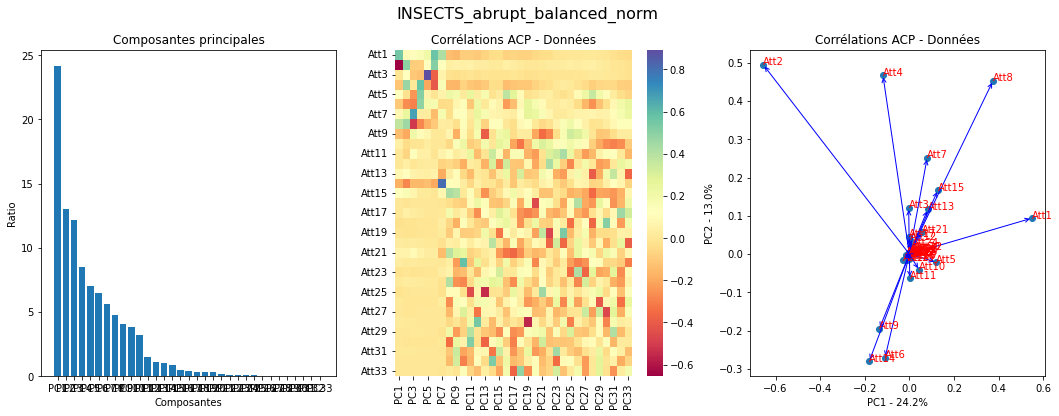

In [25]:
plot_PCA_infos(DATASETS['INSECTS_abrupt_balanced_norm']['name'],
               ratio_comp,
               weights_df,
               "Global")

<strong>| Définition de la fonction <a href="#plot_PCA_infos"> plot_PCA_infos</a> |</strong>

**Plots** - Données en composantes principales

---
--- Plots Données en ACP
--- Données en composantes principales..
--- Données en composantes principales..
--- Enregistrement des figures..
---


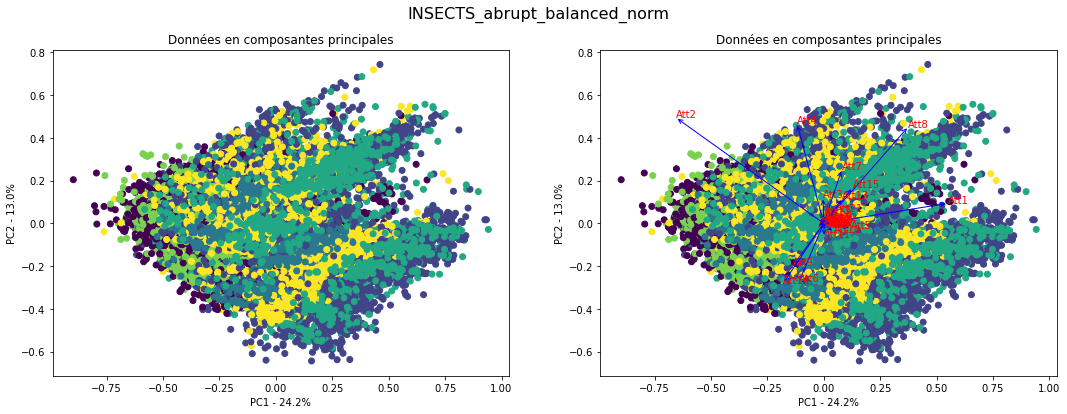

In [26]:
plot_PCA_data(DATASETS['INSECTS_abrupt_balanced_norm']['name'],
              dataset_X,
              dataset_Y_real,
              dataset_X_PCA,
              weights_df,
              "global")

<strong>| Définition de la fonction <a href="#plot_PCA_data"> plot_PCA_data</a> |</strong>

<b>Réduction LDA</b>

In [27]:
dataset_X_LDA, dataset_Y_LDA, ratio_comp = reduce_LDA(dataset_X, dataset_Y_real)

--- Réduction en ACP
--- Entrées :  (52848, 33)
--- LDA :  (52848, 5)
--- Axe 1 :  65.4 %
--- Axe 2 :  18.7 %
--- Axe 3 :  11.0 %


<strong>| Définition de la fonction <a href="#reduce_LDA"> reduce_LDA</a> |</strong>

**Données**

In [28]:
dataset_df_LDA = pd.DataFrame(dataset_X_LDA,
             columns=['Axe ' + str(_) for _ in range(1, len(ratio_comp) + 1)])
dataset_df_LDA

,Axe 1,Axe 2,Axe 3,Axe 4,Axe 5
0,-0.866924,1.184565,0.422580,0.195042,-0.226141
1,-0.699691,1.078184,0.323850,-2.131108,1.688301
2,-4.695759,-4.253616,-1.395817,-0.967700,-0.044737
3,-1.724434,1.459619,0.227735,0.838210,0.792572
4,-0.057328,-0.415007,-0.215533,1.046540,0.034047
...,...,...,...,...,...
52843,2.013317,-0.477227,1.073993,-0.882901,-1.079804
52844,2.708915,-0.469471,2.148173,-0.124253,0.983232
52845,1.983537,-1.139000,1.812686,-1.231219,-0.492453
52846,2.341012,-1.813853,1.479355,-0.448601,-1.797391


In [29]:
dataset_df_LDA.to_csv(os.path.join(DATASETS['INSECTS_abrupt_balanced_norm']['results-dir']['reduction-dir'],
                                   'LDA-Global' + '.csv'),
          index=False)

**Plots**

---
--- Plots Données en ACP
--- Données avec labels réelles..
--- Données avec labels prédites..
--- Enregistrement des figures..
---


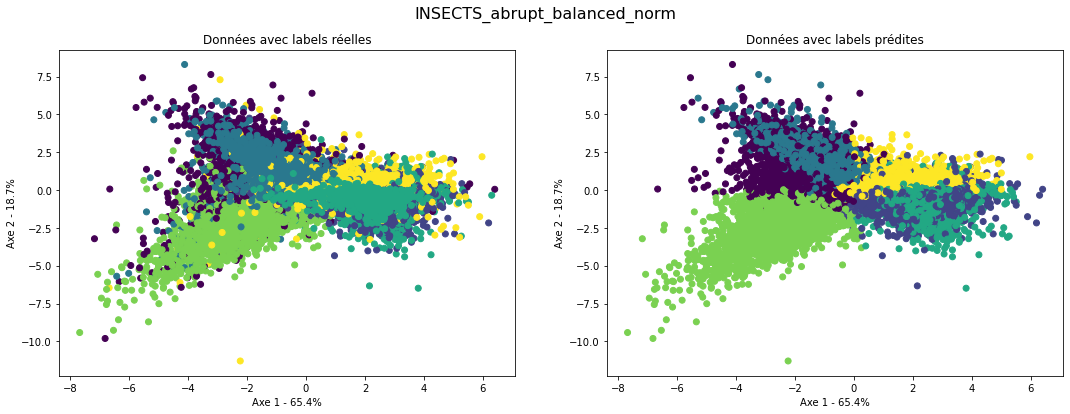

In [30]:
plot_LDA(DATASETS['INSECTS_abrupt_balanced_norm']['name'],
         dataset_X,
         dataset_Y_real,
         dataset_X_LDA,
         dataset_Y_LDA,
         "global")

<strong>| Définition de la fonction <a href="#plot_LDA"> plot_LDA</a> |</strong>

<b>Evaluations algorithmes de clustering</b>

In [31]:
evaluation_dataset = dict()
evaluation_dataset['global'] = dict()

K-means

In [32]:
evaluation_dataset['global']['kmeans'] = algo_clustering("kmeans", dataset_X, dataset_Y_real)

---
--- Clustering..
--- Evaluation..
--- ARI =>  0.07506445331277288
--- Purity =>  0.3129919769906146
----------------------------------------------------- 
---- Calcul de l'entropie de la matrice de la matrice 
----------------------------------------------------- 
---- entropie mpoyenne : 1.521
---- entropies des clusters : {0: 1.498, 1: 1.763, 2: 0.96, 3: 1.626, 4: 1.688, 5: 1.59}
----------------------------------------------------- 
--- entropy =>  (1.521, {0: 1.498, 1: 1.763, 2: 0.96, 3: 1.626, 4: 1.688, 5: 1.59})
------------------------------------------------------- 
---- Calcul de l'indice Davies&Bouldin-DB de la matrice 
------------------------------------------------------- 
---- DB Score :  7.479964309432003
------------------------------------------------------- 
--- DB =>  7.479964309432003
--------------------------------------------------------- 
---- Calcul de l'indice Calinsky&Harabsz-CH de la matrice 
--------------------------------------------------------- 
---

<strong>| Définition de la fonction <a href="#algo_clustering"> algo_clustering</a> |</strong>

HDBSCAN

In [ ]:
evaluation_dataset['global']['hdbscan'] = algo_clustering("hdbscan", dataset_X, dataset_Y_real)

---
--- Clustering..


<strong>| Définition de la fonction <a href="#algo_clustering"> algo_clustering</a> |</strong>

In [ ]:
evaluation_dataset

<b>Traitement du drift concept</b>

Traitement de chaque partie cohérente (Hors concept drift)

In [ ]:
def traitement_par_partie(dataset_name, class_column_name, dataset_df, start_part, end_part, evaluation_dataset) :
    print("|||| ", start_part, "-", end_part, " ||||")
    
    
    # General
    if end_part == None :
        dataset_X = dataset_df.iloc[start:,:-1].to_numpy()
        dataset_Y_real = dataset_df.iloc[start:,-1].to_numpy()
    else :
        dataset_X = dataset_df.iloc[start:end_part,:-1].to_numpy()
        dataset_Y_real = dataset_df.iloc[start:end_part,-1].to_numpy()
    
    
    
    # Réduction ACP
    dataset_X_PCA, ratio_comp, weights = reduce_PCA(dataset_X, dataset_Y_real)
    
    dataset_df_PCA = pd.DataFrame(dataset_X_PCA,
             columns=['PC' + str(_) for _ in range(1, len(ratio_comp) + 1)])
    
    dataset_df_PCA.to_csv(os.path.join(DATASETS[dataset_name]['results-dir']['reduction-dir'],
                                   'PCA-' + str(start_part) + '-' + str(end_part) + '.csv'),
          index=False)
    
    weights_df = pd.DataFrame(weights,
                          columns=['PC' + str(_) for _ in range(1, len(ratio_comp) + 1)],
                          index=dataset_df.drop(class_column_name, inplace=False, axis=1).columns)
    
    dataset_df_PCA.to_csv(os.path.join(DATASETS[dataset_name]['results-dir']['reduction-dir'],
                                   'PCA_Correlations-'  + str(start_part) + '-' + str(end_part) + '.csv'),
          index=False)
    
    plot_PCA_infos(DATASETS[dataset_name]['name'],
               ratio_comp,
               weights_df,
               str(start_part) + '-' + str(end_part))
    
    plot_PCA_data(DATASETS[dataset_name]['name'],
              dataset_X,
              dataset_Y_real,
              dataset_X_PCA,
              weights_df,
              str(start_part) + '-' + str(end_part))
    
    
    # Réduction LDA
    dataset_X_LDA, dataset_Y_LDA, ratio_comp = reduce_LDA(dataset_X, dataset_Y_real)
    
    dataset_df_LDA = pd.DataFrame(dataset_X_LDA,
             columns=['Axe ' + str(_) for _ in range(1, len(ratio_comp) + 1)])
    
    dataset_df_LDA.to_csv(os.path.join(DATASETS[dataset_name]['results-dir']['reduction-dir'],
                                   'LDA-' + str(start_part) + '-' + str(end_part) + '.csv'),
          index=False)
    
    plot_LDA(DATASETS[dataset_name]['name'],
         dataset_X,
         dataset_Y_real,
         dataset_X_LDA,
         dataset_Y_LDA,
         str(start_part) + '-' + str(end_part))
    
    
    
    # Evaluation des algorithmes
    evaluation_dataset[str(start_part) + '-' + str(end_part)] = dict()
    
    evaluation_dataset[str(start_part) + '-' + str(end_part)]['kmeans'] = algo_clustering("kmeans", dataset_X, dataset_Y_real)
    
    evaluation_dataset[str(start_part) + '-' + str(end_part)]['hdbscan'] = algo_clustering("hdbscan", dataset_X, dataset_Y_real)

parties

In [ ]:
start_parts = [0, 14351, 19549, 33239, 38681, 39509]
end_parts = [14351, 19549, 33239, 38681, 39509, None]

for start, end in zip(start_parts, end_parts) :
    traitement_par_partie('INSECTS_abrupt_balanced_norm',
                          'class',
                          dataset_df, 
                          start,
                          end,
                          evaluation_dataset)

In [ ]:
## Evaluation
eval_path = os.path.join(DATASETS['INSECTS_abrupt_balanced_norm']['results-dir']['evaluation-dir'],
                         DATASETS['INSECTS_abrupt_balanced_norm']['name'] + '.meta')

with open(eval_path, 'w') as eval_file:
    json.dump(evaluation_dataset, eval_file)


## Vérification du processus
with open(eval_path, 'r') as eval_file:
    print("Informations ont été enregistrées avec succès !")

<b>Overlapping</b>

Il faut analyser davantage l'overlapping (exemple est ce qu'il s'agit d'un rapport avec la le concept drift ou non)

<strong> --- <a href="#SOMMAIRE"> SOMMAIRE </a> --- </strong>

<hr>
<div style="display: flex;">
    <div style="margin: 10px;"><strong><a href="./I-Introduction.ipynb">précédent</a></strong></div>
    <div style="margin: 10px;"><strong><a href="">suivant</a></strong></div>
</div>